In [91]:
import os
from datetime import datetime
import folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import Point, LineString
from geographiclib.geodesic import Geodesic
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from cycler import cycler
from utils import read_l3, get_sensor_grid
import utils_plots

from pyffp import calc_footprint_FFP as myfootprint
from pyffp import calc_footprint_FFP_climatology as myfootprintclim

from pyffp.utils import get_dd
from pyffp.utils import contour_to_gdf
import geopy
from geopy.distance import geodesic
# plt.style.use('classic')
# plt.style.use('dark_background')
# plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('seaborn-v0_8-dark-palette')
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# new_colors = [c for c in colors if c != colors[1]] + [colors[1]]
# mpl.rcParams['axes.prop_cycle'] = cycler(color=new_colors)

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2024-04-09.csv' # linux
# filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L3_2024-04-09.csv" # windows
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L3_2024-08-12_ch4gapfilled.csv" # windows
# filepath = os.path.join(os.getcwd(), 'US-AMS', 'US-AMS_HH_202205241000_202312201430.csv')
l3 = read_l3(filepath)
l3

# predictors = 'baseflux'
# filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'
# rf = read_l3(filepath).add_suffix('_RF')

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L1_fluxnet_2024-01-30.csv'
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L1_fluxnet_2024-01-30.csv"
l1_fluxnet = read_l3(filepath)

l3['V_SIGMA'] = l1_fluxnet.loc[l1_fluxnet.index == l3.index, 'V_SIGMA']
# l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':]], axis=1)

soil_dateformat = 'yyyy-mm-dd HH:MM:SS+00.00' # from ATMOS484 package

## Get geodataframe of soil sensor locations derived from logger locations

dataloggers, sensors, origin = get_sensor_grid()

zones = sensors.dissolve(by=['zone'], as_index=False)
# zones.drop(columns=['serial', 'port', 'logger', 'teros_num', 'status'])

zonesm = zones.to_crs(3174)
# zonesm.geometry = zonesm.geometry.convex_hull.buffer(distance=6.25, cap_style=1, quad_segs=1)
zonesm.geometry = zones.geometry.convex_hull.apply(lambda g: g.buffer(distance=6.25, cap_style=3, join_style=2))

zones = zonesm.to_crs(4326)

# utils_plots.plot_sensor_grid(dataloggers, sensors, zones)

Azimuth from logger 0 to 3 = -66.67909064882072
Azimuth from logger 7 to 10 = -66.51445741226922
Origin = (41.70131583022141, -87.99745859087017)


In [93]:
## Read Zentra soil sensor data, partition into zones

# filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L0_2024-04-09_biomet.csv'
filepath = r"C:\Users\ottob\data\atmos-flux-data\processed\ATMOS_L0_2024-04-09_biomet.csv"
met = read_l3(filepath, datecol='datetime')

# df = met.loc[datestart:dateend, :]

df = met

def read_soil(df, column):
    df = df.loc[:, df.columns.str.match(f'{column}_([0-9]+)([0-9]+)(?!cm)')]
    df = df.melt(var_name='sensor', value_name=column, ignore_index=False)
    xy = df.loc[:, 'sensor'].str.extract(f'{column}([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
    df = pd.concat([df, xy], axis=1)
    df = df.merge(sensors[['x','y','lat','lon']], on=['x','y']).set_index(df.index)
    return df

soilT = df.loc[:, df.columns.str.match('Tsoil_([0-9]+)([0-9]+)(?!cm)')]

## Make dataframe of soilT

soilT = soilT.melt(var_name='Tsoil_sensor', value_name='Tsoil', ignore_index=False)

xy = soilT.loc[:, 'Tsoil_sensor'].str.extract('Tsoil_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilT = pd.concat([soilT, xy], axis=1)

soilT = soilT.merge(sensors[['x','y','lat','lon','zone']], on=['x','y']).set_index(soilT.index)

soilM = df.loc[:, df.columns.str.match('SWC_([0-9]+)([0-9]+)(?!cm)')]
soilM = soilM.melt(var_name='SWC_sensor', value_name='SWC', ignore_index=False)

xy = soilM.loc[:, 'SWC_sensor'].str.extract('SWC_([0-9]+)([0-9]+)').rename(columns={0:'x', 1:'y'}).astype('int64')
soilM = pd.concat([soilM, xy], axis=1)

soilM = soilM.merge(sensors[['x','y','lat','lon','zone']], on=['x','y']).set_index(soilM.index)

soil = pd.concat([soilT, soilM[['SWC', 'SWC_sensor']]], axis=1)
soil.loc[:, 'date'] = soil.index
soil = gpd.GeoDataFrame(soil, 
                        geometry=gpd.points_from_xy(soil['lon'], soil['lat']),
                        crs=4326).sort_values(by=['date','y','x'])

soil = soil.sort_values(by=['date','y','x'])

monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')

zones = zones.merge(soil.groupby('zone')[['Tsoil', 'SWC']].mean(), on='zone')

C:\Users\ottob\AppData\Local\Temp\ipykernel_20624\552311124.py:46: FutureWarning: The provided callable <function mean at 0x0000015CBADE6160> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', np.mean), SWC=('SWC', np.mean)).reset_index().set_index('date')


In [95]:
FFPtimescale = '3daily'
soil = soil.loc[l3.index[0]:l3.index[-1], :]
monthly = soil.groupby([soil.date.dt.to_period('M'), 'zone']).agg(Tsoil=('Tsoil', 'mean'), SWC=('SWC', 'mean')).reset_index().set_index('date')
monthly
weekly = soil.groupby([soil.date.dt.to_period('W'), 'zone']).agg(Tsoil=('Tsoil', 'mean'), SWC=('SWC', 'mean')).reset_index().set_index('date')
# daily3 = soil.groupby([soil.date.dt.to_period('3D'), 'zone']).agg(Tsoil=('Tsoil', 'mean'), SWC=('SWC', 'mean')).reset_index().set_index('date')
daily3 = pd.concat([soil.loc[soil.zone == zone, ['Tsoil', 'SWC']].resample('3D').mean().assign(zone=zone) for zone in range(16)], axis=0).sort_index()

if FFPtimescale == '3daily':
    soilt = daily3
elif FFPtimescale == 'weekly':
    soilt = weekly
elif FFPtimescale == 'monthly':
    soilt = monthly

if FFPtimescale == '3daily':
    periods = pd.DataFrame({'start_time': soilt.index.strftime("%Y-%m-%d").unique(), 'end_time': (soilt.index + pd.DateOffset(3)).strftime("%Y-%m-%d").unique()})
else:
    periods = pd.DataFrame({'start_time': soilt.index.start_time.strftime('%Y-%m-%d').unique(), 'end_time': soilt.index.end_time.strftime('%Y-%m-%d').unique()})

End time: 2022-05-27
End time: 2022-05-30
End time: 2022-06-02
End time: 2022-06-05
End time: 2022-06-08
End time: 2022-06-11
End time: 2022-06-14
End time: 2022-06-17
End time: 2022-06-20
End time: 2022-06-23
End time: 2022-06-26
End time: 2022-06-29
End time: 2022-07-02
End time: 2022-07-05
End time: 2022-07-08
End time: 2022-07-11
End time: 2022-07-14
End time: 2022-07-17
End time: 2022-07-20
End time: 2022-07-23
End time: 2022-07-26
End time: 2022-07-29
End time: 2022-08-01
End time: 2022-08-04
End time: 2022-08-07
End time: 2022-08-10
End time: 2022-08-13
End time: 2022-08-16
End time: 2022-08-19
End time: 2022-08-22
End time: 2022-08-25
End time: 2022-08-28
End time: 2022-08-31
End time: 2022-09-03
End time: 2022-09-06
End time: 2022-09-09
End time: 2022-09-12
End time: 2022-09-15
End time: 2022-09-18
End time: 2022-09-21
End time: 2022-09-24
End time: 2022-09-27
End time: 2022-09-30
End time: 2022-10-03
End time: 2022-10-06
End time: 2022-10-09
End time: 2022-10-12
End time: 202

(array([1.0000e+00, 1.0918e+04, 2.3586e+04, 2.2110e+03, 1.1180e+03,
        8.3300e+02, 6.5600e+02, 5.0800e+02, 3.6800e+02, 1.9600e+02]),
 array([-0.00367425, -0.00104363,  0.001587  ,  0.00421762,  0.00684825,
         0.00947887,  0.0121095 ,  0.01474013,  0.01737075,  0.02000138,
         0.022632  ]),
 <BarContainer object of 10 artists>)

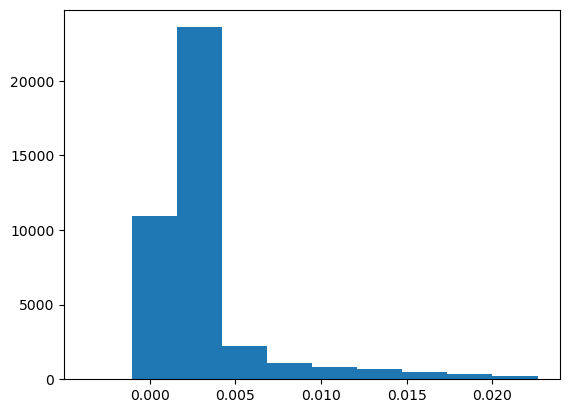

In [96]:
# fwfs = np.empty((201,201,))
for t, timeperiod in enumerate(periods['end_time']):
    # start_time = timeperiod
    end_time = timeperiod
    print(f'End time: {end_time}')
    try: 
        fwf = np.load(os.path.join(os.getcwd(), 'output', 'fwf', f'fwf_ch4_flux_{FFPtimescale}_{timeperiod}.npy'))
        fwf = np.expand_dims(fwf, -1)
    except:
        print(f'No footprint found for {timeperiod}')
        fwf = np.full((201, 201, 1), np.nan)
        fwfs = np.concatenate([fwfs, fwf], axis=-1)
        continue
    if t==0:
        fwfs = fwf
    else:
        fwfs = np.concatenate([fwfs, fwf], axis=-1)
    # print(fwf.shape)
# plt.imshow(fwf)
plt.hist(fwf.ravel())

In [99]:
FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f']

Series([], Name: f, dtype: float64)

In [97]:
fp = os.path.join(os.getcwd(), 'output', 'fwf')
x_2d_dd = np.load(os.path.join(fp, 'x_2d_dd.npy'))
y_2d_dd = np.load(os.path.join(fp, 'y_2d_dd.npy'))
fluxsp = 'ch4_flux'
for t in range(fwfs.shape[-1]):
    p = soilt.index.unique()[t]
    print(f'Period: {p}')
    # print(t)
    fwf = fwfs[:,:,t]
    # print(fwf.shape)
    
    FWFS = gpd.GeoDataFrame(np.ravel(fwf), columns = ['f'], 
                            geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
                            crs=4326)
    FWFS = FWFS.to_crs(3174)
    FWFS.geometry = FWFS.geometry.convex_hull.apply(lambda g: g.buffer(distance=1, cap_style=3, join_style=2))
    FWFS = FWFS.to_crs(4326)
    
    print('Finding fluxes in zones')
    # monthly.loc[yearmonth, f'f_{fluxsp}_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f'].mean() for i in range(16)]
    
    soilt.loc[p, f'f_{fluxsp}_mean'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f'].apply(np.nanmin) for i in range(16)]
    ftime = gpd.GeoDataFrame(np.ravel(fwf), columns = ['f'], 
                            geometry=gpd.points_from_xy(np.ravel(x_2d_dd), np.ravel(y_2d_dd)), 
                            crs=4326)
    if t==0:
        ftimes = ftime
    else:
        ftimes = pd.concat([ftimes, ftime], axis=0)
    print(FWFS['f'])
    fig, ax = plt.subplots()
    FWFS.plot(column='f', 
              legend = True,   
              vmin = -0.04, 
              vmax = 0.04,
              legend_kwds={"label": "Footprint-weighted flux", "orientation": "vertical"}, 
              ax=ax)
    plt.show()
    zones.loc[:, f'fsum_{fluxsp}'] = [FWFS.loc[FWFS.geometry.within(zones.geometry.iloc[i]), 'f'].mean() for i in range(16)]
    print('Next period')

soilt.loc[:, 'f_ch4_flux_mean'] = soilt.replace(soilt['f_ch4_flux_mean'].min(), np.nan)

Period: 2022-05-24 00:00:00
Finding fluxes in zones


ValueError: Must have equal len keys and value when setting with an ndarray

KeyError: 'f_ch4_flux_mean'

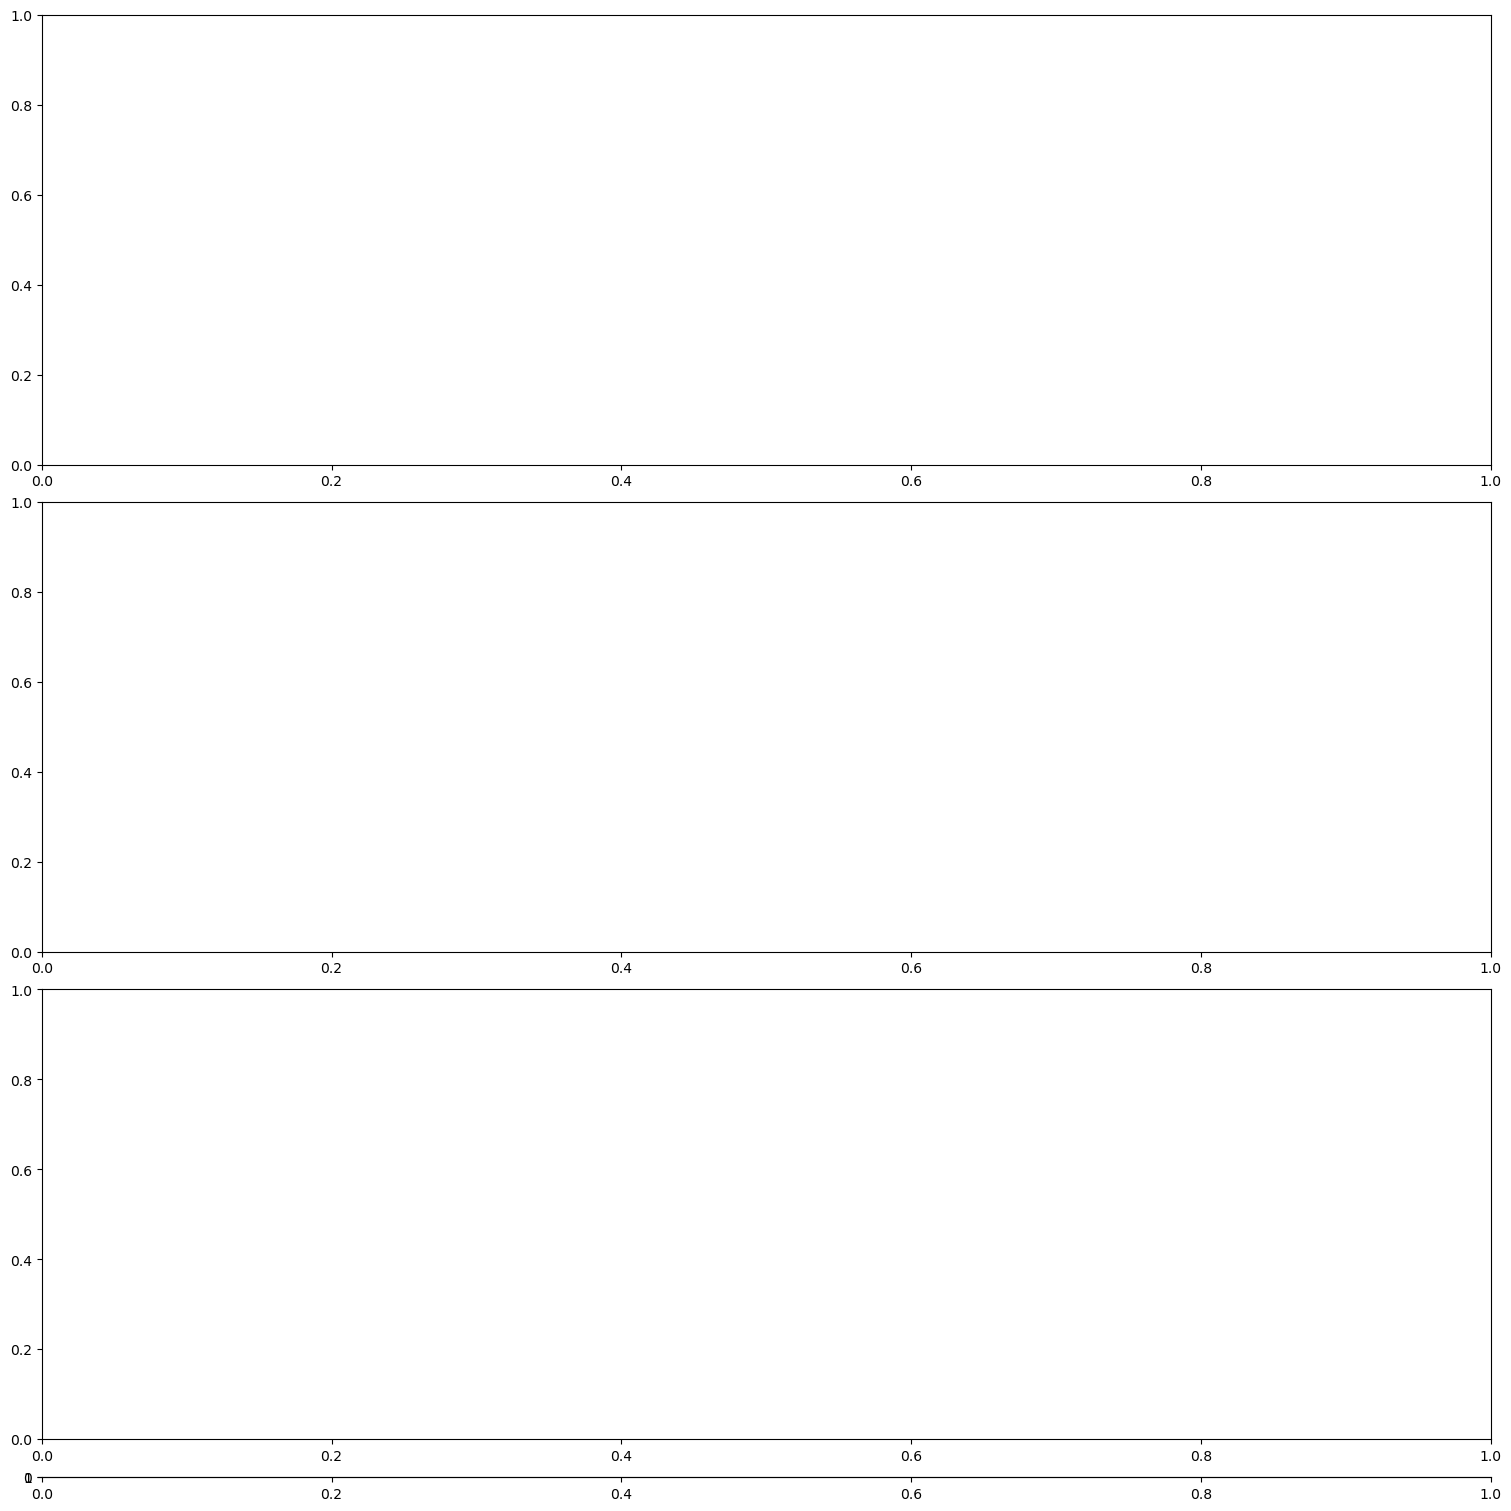

In [16]:
# plt.style.use('seaborn-v0_8-dark-palette')
plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('dark_background')
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# new_colors = [c for c in colors if c != colors[1]] + [colors[1]]
# mpl.rcParams['axes.prop_cycle'] = cycler(color=new_colors)
plt.rcParams["axes.prop_cycle"] = cycler("color", cm.tab20.colors)
# fig = plt.figure(layout='constrained')
rows = [['f_ch4_flux_mean'], ['Tsoil'], ['SWC']]
rowunits = ['unitless', 'deg C', 'm3/m3']
mosaic = rows + [['legend']]
fig = plt.figure(constrained_layout=True, figsize=(5*len(rows),15))
height_ratios = [1]*(len(rows)) + [0.001]
# height_ratios = [1]*(len(IGBPs))
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios': height_ratios,})
# fig, axs = plt.subplots(3,1,figsize=(15,15))

for zone in soilt['zone'].unique():    
    st = soilt.loc[soilt['zone']==zone, rows[1]]
    ts = pd.to_datetime(st.index.end_time.strftime('%Y-%m-%d'))
    xlim = (ts[0], ts[-1])
    for i, row in enumerate(rows):
        row = row[0]
        ax = axs[row]
        st = soilt.loc[soilt['zone']==zone, row]
        ax.plot(ts, st, label= f'Zone {zone}')
        ax.set(ylabel = f'{row} [{rowunits[i]}]', xlim=xlim)
    h, l = axs['SWC'].get_legend_handles_labels()
axs['legend'].legend(h,l, mode='expand', ncols=len(soilt['zone'].unique())//2)
axs['legend'].set_axis_off()
    
plt.suptitle(f'Footprint-weighted fluxes and soil data over all soil zones, at {FFPtimescale} timescale')
# ax.legend(loc='lower right')
# plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), 'output', f'atmos_fwf_zonal_ch4_flux_{FFPtimescale}.png'))